<a href="https://colab.research.google.com/github/AmanPriyanshu/1800/blob/master/Visualisaing_neuron_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import tensorflow as tf

## CREATING A DATASET:

In [2]:
x = np.array([3 * np.random.random_sample((3,)) - 3 for _ in range(2500)] + [3 * np.random.random_sample((3,)) + 3 for _ in range(2500)] + [6 * np.random.random_sample((3,)) - 2.75 for _ in range(2500)] + [-5 * np.random.random_sample((3,)) - 2.8 for _ in range(2500)])
y = np.array([0 for _ in range(2500)] + [1 for _ in range(2500)] + [2 for _ in range(2500)] + [3 for _ in range(2500)])

In [3]:
print(x.shape, y.shape)

(10000, 3) (10000,)


## SHUFFLING:

In [4]:
indexes = np.arange(x.shape[0])
np.random.shuffle(indexes)

x = x[indexes]
y = y[indexes]

## CREATING A BASIC MODEL:

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [6]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [7]:
model.fit(x, y, epochs=25, validation_split=0.2)

Epoch 1/25
250/250 [==============================] - 0s 2ms/step - loss: 1.8679 - acc: 0.3170 - val_loss: 1.2678 - val_acc: 0.5110
Epoch 2/25
250/250 [==============================] - 0s 1ms/step - loss: 1.1352 - acc: 0.5426 - val_loss: 1.0390 - val_acc: 0.5865
Epoch 3/25
250/250 [==============================] - 0s 1ms/step - loss: 0.9799 - acc: 0.6047 - val_loss: 0.8978 - val_acc: 0.6195
Epoch 4/25
250/250 [==============================] - 0s 1ms/step - loss: 0.8515 - acc: 0.6446 - val_loss: 0.8000 - val_acc: 0.6780
Epoch 5/25
250/250 [==============================] - 0s 1ms/step - loss: 0.7547 - acc: 0.6871 - val_loss: 0.7059 - val_acc: 0.7085
Epoch 6/25
250/250 [==============================] - 0s 1ms/step - loss: 0.6623 - acc: 0.7194 - val_loss: 0.6112 - val_acc: 0.7585
Epoch 7/25
250/250 [==============================] - 0s 1ms/step - loss: 0.5641 - acc: 0.7778 - val_loss: 0.5073 - val_acc: 0.8105
Epoch 8/25
250/250 [==============================] - 0s 1ms/step - loss: 0.

## WELL PRETTY EFFICIENT:

### Let's take a look at it

In [8]:
classes = 4

In [9]:
y_pred = model.predict(x)
y_pred = np.array([np.argmax(i) for i in y_pred])

In [10]:
groups = {}
for i in range(classes):
  groups.update({i:[]})

for i,j in zip(y, y_pred):
    groups[i].append(j)
    
p_error = {}
for i in range(classes):
  p_error.update({i:[]})

for key, item in groups.items():
    for i in range(4):
        p_error[key].append(item.count(i))
    total = sum(p_error[key])
    p_error[key] = [round(i/total, 5) for i in p_error[key]]

_ = [print(key,':',item) for key, item in p_error.items()]

0 : [0.938, 0.0, 0.062, 0.0]
1 : [0.0, 1.0, 0.0, 0.0]
2 : [0.1784, 0.0012, 0.8204, 0.0]
3 : [0.0, 0.0, 0.0, 1.0]


### Directed Error Maps

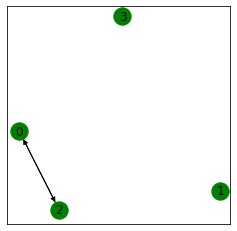

In [11]:
import networkx as nx 
from matplotlib import pyplot as plt

def error_graph(p_error):
    
    G = nx.DiGraph() 
    for i in range(classes):
        G.add_node(i)
    
    for key, item in p_error.items():
        for i,x in enumerate(item):
            x = round(x, 3)
            if i!=key and x>0.01:
                G.add_edge(key, i, weight=x)
    
    plt.figure(figsize =(4, 4))
    plt.title("Error Graph")
    nx.draw_networkx(G, node_color ='green')
    
error_graph(p_error)

## Now, let's start building our thing:

Defining a class, which takes test case and the model as input.

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class NeuronImportance:
  def __init__(self, x, y, model, loss):
    self.x_test = x
    self.y_test = y
    self.model = model
    self.loss = loss
    self.original_weights = model.get_weights()
    self.initial_weights = None
    self.active_weights = None
    self.size_list = None
    self.losses = None
    self.t = None
    self.epoch = 1
    self.neuron_importance = []

  def flattener(self, weights):
    weights_flat = []
    for w in weights:
      weights_flat += [i for i in w.flatten()]
    weights_flat = np.array(weights_flat)
    return weights_flat


  def reshaper(self, weights):
    count = 0
    self.active_weights = []
    for shape in self.size_list:
      neurons = np.prod(np.array([i for i in shape]))
      w = weights[count:count+neurons]
      w = np.reshape(w, shape)
      self.active_weights.append(w)
      count += neurons
    self.active_weights = np.array(self.active_weights)


  def single_iteration(self):
    og_loss = self.model.evaluate(self.x_test, self.y_test, verbose=0)[0]
    model_initial = tf.keras.models.clone_model(self.model)
    model_initial.compile(loss=self.loss)
    self.initial_weights = model_initial.get_weights()
    total_neurons = sum([i.flatten().shape[0] for i in model_initial.get_weights()])
    self.t = tqdm(total=total_neurons)
    self.size_list = [i.shape for i in self.initial_weights]
       
    original_weights_flat = self.flattener(self.original_weights)
    initial_weights_flat = self.flattener(self.initial_weights)

    ## Looping through each weight:

    self.losses = []
    
    for index in range(initial_weights_flat.shape[0]):
      active_weights_flat = np.concatenate((original_weights_flat[:index] , np.array([initial_weights_flat[index]]) , original_weights_flat[index+1:]))
      self.reshaper(active_weights_flat)
      model_initial.set_weights(self.active_weights)
      active_loss = model_initial.evaluate(self.x_test, self.y_test, verbose=0)
      self.losses.append(active_loss)
      self.t.update(1)
      self.t.set_postfix({'Previous Loss': round(self.losses[-1], 3), 'Original Loss': og_loss, 'Random Iteration': self.epoch})
      self.t.refresh()
    self.t.close()
    self.losses = np.array(self.losses)
    self.losses = np.abs(self.losses - og_loss)
    self.neuron_importance.append(self.losses)
    self.epoch += 1

  def draw_2d(self, data, layer, one_d=False):
    plt.clf()
    heatmap = plt.pcolor(data)
    for y in range(data.shape[0]):
      for x in range(data.shape[1]):
          plt.text(x + 0.5, y + 0.5, '%.4f' % data[round(y, 3), round(x,3)],
                  horizontalalignment='center',
                  verticalalignment='center',
                  )
    plt.colorbar(heatmap)
    plt.ylim([0, data.shape[0]])
    if one_d:
      plt.rcParams["figure.figsize"] = (6,6)
    else:
      plt.rcParams["figure.figsize"] = (6,1)
    if layer%2 == 0:
      plt.title("WEIGHTS of LAYER "+ str(layer//2+1))
    else:
      plt.title("BIAS of LAYER "+ str(layer//2+1))
    plt.show()

  def evaluate(self, epochs=5, plot=False):
    for _ in range(epochs):
      self.single_iteration()

    self.neuron_importance = np.array(self.neuron_importance)
    self.neuron_importance = np.sum(self.neuron_importance, axis=0)
    self.neuron_importance = 1 - self.neuron_importance/np.sum(self.neuron_importance)
    self.reshaper(self.neuron_importance)
    self.neuron_importance = self.active_weights

  def plot(self):
    if True:
      for layer, map in enumerate(self.neuron_importance):
        if np.array(map.shape).shape[0] == 2:
          self.draw_2d(map, layer)
        else:
          self.draw_2d(np.array([map]), layer, one_d=True)

In [13]:
ni = NeuronImportance(x, y, model, loss='sparse_categorical_crossentropy')
ni.evaluate(epochs=10, plot=True)

100%|██████████| 47/47 [00:10<00:00,  4.31it/s, Previous Loss=0.196, Original Loss=0.149, Random Iteration=10]


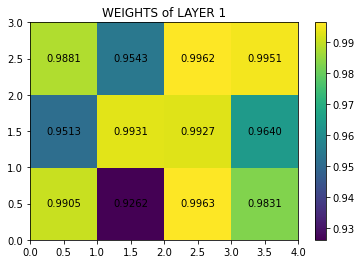

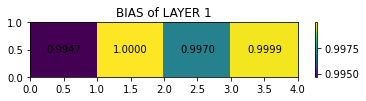

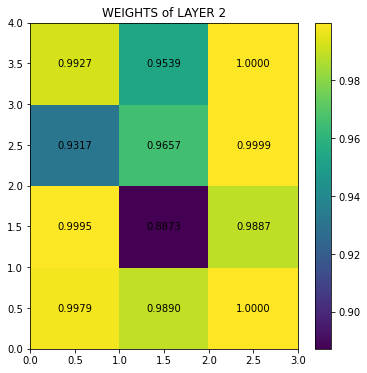

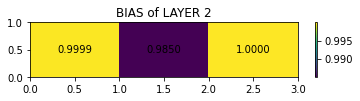

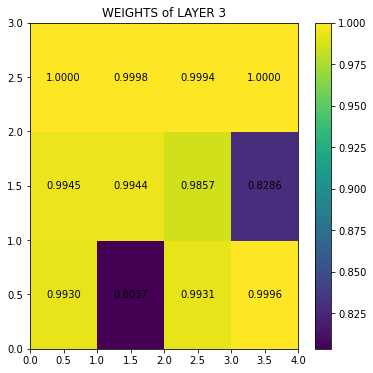

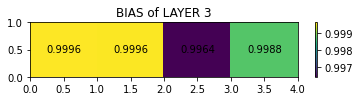

In [14]:
ni.plot()